### One Owner Model

As a benchmark to the revenues generated from the producers inside the water regulation procedure, we will have a look at how a theoretical river system behaves, where every power plant is operated by one decision maker. The revenues are then distributed according to how much production capacity the individual producers have: If producer A has a total of 1 and producer B has a total of 2 for all equivalents, then B gets 2/3 of the revenue and A gets 1/3.  
We will see how much revenue will be generated and compare this to the revenue generated in the water regulation system.  

We can leave out the water regulation rules in these optimization models. We develop 

* Stochastic Bidding Model
* Stochastic Short-Term Optimization Model

We obviously don't have to do any balancing other than necessary in this problem, as we can freely adjust how much water we use without any constraint on average discharge. 


In [167]:
using JuMP
using CPLEX
using Distributions
using LinearAlgebra
using Statistics
using Dates
using DataFrames
using SDDP
using Plots
import CSV
using JSON
try
    using Revise
catch e
    @warn "Error initializing Revise" exception=(e, catch_backtrace())
end

includet(pwd() * "\\Water_Regulation\\WaterRegulation.jl")
using .WaterRegulation

In [168]:
filepath_Ljungan = pwd() * "\\Water_Regulation\\TestDataWaterRegulation\\Ljungan.json"
filepath_prices = pwd() *  "\\Data\\Spot Prices\\prices_df.csv"
filepath_results = pwd() * "\\Results\\LambdaZero\\"
R, K, J = read_data(filepath_Ljungan)
println("Reservoirs: ", [r.dischargepoint for r in R])
println("Power Plants - Spill Reference")
for k in K
    println("$(k.name) -  $(k.spillreference)")
end

Reservoirs: ["Flasjon", "Holsmjon"]
Power Plants - Spill Reference
Flasjo -  0.58
Trangfors -  1.05
Ratan -  1.15
Turinge -  1.05
Bursnas -  1.05
Jarnvagsforsen -  1.45
Parteboda -  1.4
Hermansboda -  1.4
Ljunga -  1.45
Nederede -  2.4
Skallbole -  2.65
Matfors -  2.5
Viforsen -  1.6


### Bidding Model

We approximate the bidding problem by using linear interpolation of volumes and presetting price Points, for example based on probabilities. From that we obtain the delivery obligation.

$$
y_t = \frac{c_t - P_{t,i} }{P_{t,i+1} - P_{t,i}} \cdot x_{i,t} + \frac{P_{t,i+1} - c_t }{P_{t,i+1} - P{t,i}} \cdot x_{i+1,t}, \qquad \text{if} \qquad P_{t,i} \leq c_t \leq P_{t,i+1}
$$

NamedTuple{(:inflow, :price), Tuple{Dict{Reservoir, Float64}, Vector{Float64}}}[(inflow = ________________________________
Flasjon  | 0.4     
Holsmjon | 0.4     
, price = [0.037153628220389145, 0.5242922048100753, 0.15326723007820575, 0.09988102232700868, 0.9829337224348456, 0.4256860505001977, 0.7696878042447812, 0.03327929382123851, 0.10801935803815521, 0.14111795344155298, 0.5585637176107207, 0.826196479607222, 0.7033182026570607, 0.9323744259281954, 0.25788216560788757, 0.526318836087059, 0.004355667011553099, 0.7091843428216341, 0.4809712211276337, 0.05382613630311084, 0.8164939876440673, 0.43734545531071534, 0.8394318142899424, 0.42349088031781845]), (inflow = ________________________________
Flasjon  | 0.6     
Holsmjon | 0.6     
, price = [0.023052281008978937, 0.6664974439206781, 0.20733457542948042, 0.7830233408065793, 0.2646873544915601, 0.7499747800262089, 0.6167069974324692, 0.47622952821760633, 0.9512833503765634, 0.8231457548312442, 0.09808500607440007, 0.999828628350

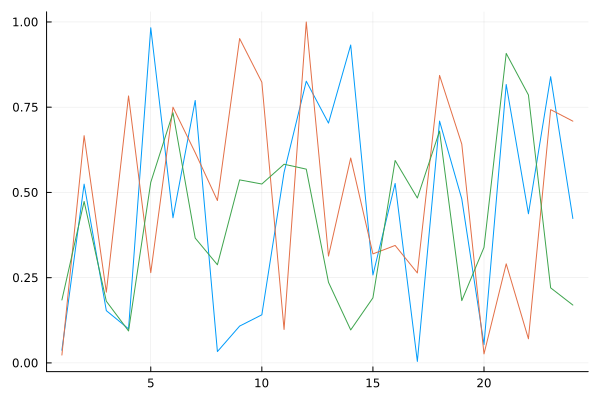

In [202]:
I = 5
T = 24
Stages = 2

mu_up = 1.0
mu_down = 0.1
S = 0.3

PPoints = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
@assert length(PPoints) == I + 1
Omega = [(inflow = Dict(r => 0.4 for r in R), price = rand(T)), (inflow = Dict(r => 0.6 for r in R), price = rand(T)), (inflow = Dict(r => 0.8 for r in R), price = rand(T))]
P = [1/length(Omega) for om in Omega]
println(Omega)
Plots.plot(x = 1:T, [om.price for om in Omega], legend = false, show=true)

In [203]:
function subproblem_builder_single_bidding(subproblem::Model, node::Int64)
    # State Variables
    @variable(subproblem, 0 <= l[r = R] <= r.maxvolume, SDDP.State, initial_value = r.currentvolume)
    @variable(subproblem, ustart[k = K], Bin, SDDP.State, initial_value = 0)
    @variable(subproblem, 0 <= x[i = 1:I+1, t = 1:T] <= sum(k.equivalent * k.spillreference for k in K), SDDP.State, initial_value = 0)
    # Transition Function
    @constraint(subproblem, increasing[i = 1:I, t=1:T], x[i,t].out <= x[i+1,t].out)
    if node == 1
        # We only concern ourselves with bidding in the first stage.
        @stageobjective(subproblem, 0)
        @constraint(subproblem, balance_transfer[r = R], l[r].out == l[r].in) # No Inflow In first stage (or fixed value)
        @constraint(subproblem, start_transfer[k = K], ustart[k].out == ustart[k].in)
    else
        # Some Constraints and variables such as production specific components only become relevant in stage >= 2
        @variable(subproblem, y[t = 1:T] >= 0)
        @variable(subproblem, a[r = R])
        @variable(subproblem, 0 <= Qreal[t = 1:T, r = R])
        @variable(subproblem, 0 <= w[t = 1:T, k = K] <= k.equivalent * k.spillreference)
        @variable(subproblem, u[t = 1:T, k = K], Bin)
        @variable(subproblem, d[t = 1:T, k = K], Bin)
        @variable(subproblem, s[r = R] >= 0)
        @variable(subproblem, z_up[t = 1:T] >= 0)
        @variable(subproblem, z_down[t = 1:T] >= 0)
        # Random Variables
        @variable(subproblem, f[r = R])
        @constraint(subproblem, watervalue[r = R], a[r] >= sum(k.equivalent for k in filter( k-> k.reservoir in find_ds_reservoirs(r), K)) * (l[r].in - l[r].out) * 0.5)
        @constraint(subproblem, clearing[t=1:T], y[t] == sum(1* x[i,t].in +  1* x[i+1,t].in for i in 1:I-1))
        @constraint(subproblem, balance[r = R], l[r].out == l[r].in - sum(Qreal[t,r] for t in 1:T) + T * f[r] - s[r])
        @constraint(subproblem, planttrans1[k = K], ustart[k].in == u[1,k])
        @constraint(subproblem, planttrans2[k = K], ustart[k].out == u[T,k])
        # Constraints
        @constraint(subproblem, startup[t = 1:T-1, k = K], d[t,k] >= u[t+1,k] - u[t,k])
        @constraint(subproblem, activeplant[t = 1:T, k = K], w[t,k] <= u[t,k] * k.equivalent * k.spillreference)
        @constraint(subproblem, production[t = 1:T, k = K], w[t,k] <= sum(Qreal[t, r] for r in find_us_reservoir(k.reservoir)) * k.equivalent)
        @constraint(subproblem, obligation[t = 1:T], y[t] == sum(w[t, k] for k in K) + z_up[t] - z_down[t])
        # Parameterize Uncertainty and Objective Function
        SDDP.parameterize(subproblem, Omega, P) do om
            for r in R
                JuMP.fix(f[r], om.inflow[r], force=true)
            end
            # Define Set of active variables for each hour
            I_t = Dict(t => 0 for t in 1:T)
            for t in 1:T
                for i in 1:I
                    if (om.price[t] >= PPoints[i]) && (om.price[t] <= PPoints[i+1])
                        I_t[t] = i
                    end
                end
            end
            # Parameterize objective through uncertain price
            @stageobjective(subproblem, sum(om.price[t] * y[t] -  mu_up * z_up[t] + mu_down * z_down[t]  - sum(S * d[t,k] for k in K) - sum(a[r] for r in R) for t in 1:T))
            # Fix / Deactivate constraints by setting their coefficients to appropriate values or all zero.
            for t in 1:T
                for i in 1:I
                    if (i == I_t[t])
                        set_normalized_coefficient(clearing[t], x[i,t].in, -((om.price[t] - PPoints[i])/(PPoints[i+1] - PPoints[i])))
                        set_normalized_coefficient(clearing[t], x[i+1,t].in, -((PPoints[i+1] - om.price[t])/(PPoints[i+1] - PPoints[i])))
                    else
                        set_normalized_coefficient(clearing[t], x[i,t].in, 0)
                        set_normalized_coefficient(clearing[t], x[i+1,t].in, 0)
                    end
                end
            end
        end
    end

end

subproblem_builder_single_bidding (generic function with 1 method)

In [204]:
model_single_bidding = SDDP.LinearPolicyGraph(
    subproblem_builder_single_bidding;
    stages = Stages,
    sense = :Max,
    upper_bound = Stages * sum(sum(k.spillreference * k.equivalent for k in K) for t in 1:T for s in 1:Stages),
    optimizer = CPLEX.Optimizer
)

A policy graph with 2 nodes.
 Node indices: 1, 2


In [205]:
SDDP.train(
    model_single_bidding;
    iteration_limit = 10,
    print_level = 1
)

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 2
  state variables : 159
  scenarios       : 3.00000e+00
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [319, 1381]
  AffExpr in MOI.EqualTo{Float64}         : [15, 76]
  AffExpr in MOI.GreaterThan{Float64}     : [301, 301]
  AffExpr in MOI.LessThan{Float64}        : [120, 744]
  VariableRef in MOI.GreaterThan{Float64} : [146, 581]
  VariableRef in MOI.LessThan{Float64}    : [147, 459]
  VariableRef in MOI.ZeroOne              : [13, 637]


numerical stability report
  matrix range     [9e-04, 2e+01]
  objective range  [4e-03, 2e+01]
  bounds range     [7e-02, 4e+04]
  rhs range        [0e+00, 0e+00]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
-------------------------------------------------------------------


         1   1.241543e+03  6.568128e+02  6.400013e-02         6   1


        10   8.294400e+02  6.568128e+02  5.730000e-01        66   1
-------------------------------------------------------------------
status         : iteration_limit
total time (s) : 5.730000e-01
total solves   : 66
best bound     :  6.568128e+02
simulation ci  :  1.077581e+03 ± 2.168873e+02
numeric issues : 0
-------------------------------------------------------------------



In [206]:
rule_single_bidding = SDDP.DecisionRule(model_single_bidding; node = 1)
sol_single_bidding = SDDP.evaluate(
    rule_single_bidding;
    incoming_state = Dict(Symbol("l[$(r.dischargepoint)]") => r.currentvolume for r in R),
    controls_to_record = [:x],
)

println([sol_single_bidding[3][:x][i].out for i in eachindex(sol_single_bidding[3][:x])])

[0.0, 0.0, 0.0, 0.0, 6.841800000000001, 6.841800000000001, 0.0, 0.0, 0.0, 0.0, 6.841800000000001, 6.841800000000001, 0.0, 0.0, 6.841800000000001, 6.841800000000001, 6.841800000000001, 6.841800000000001, 0.0, 0.0, 0.0, 0.0, 6.841800000000001, 6.841800000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.841800000000001, 6.841800000000001, 0.0, 0.0, 0.0, 0.0, 6.841800000000001, 6.841800000000001, 0.0, 0.0, 0.0, 6.841800000000001, 6.841800000000001, 6.841800000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.841800000000001, 6.841800000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.841800000000001, 6.841800000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.841800000000001, 6.841800000000001, 6.841800000000001, 6.841800000000001, 0.0, 0.0, 0.0, 6.841800000000001, 6.841800000000001, 6.841800000000001, 0.0, 0.0, 0.0, 0.0, 6.841800000000001, 6.841800000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.841800000000001, 

### Short-Term Optimization

The problem is parameterized by a known demand $y$ in the first stage.
Bidding is removed from the optimization model. Determining a discharge schedule is the most important thing about the model. For the current production day we know

* Inflow
* Price
* Obligation

In the future the parameters

* Inflow
* Price

are considered unknown.

24


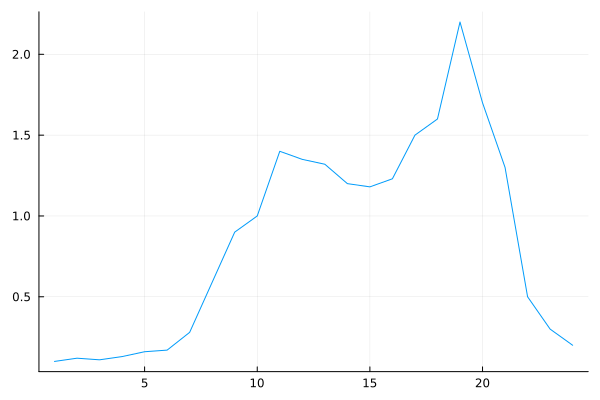

In [207]:
y_initial::Vector{Float64} = [0.1, 0.12, 0.11, 0.13, 0.16, 0.17, 0.28, 0.59, 0.9, 1.0, 1.4, 1.35, 1.32, 1.2, 1.18, 1.23, 1.5, 1.6, 2.2, 1.7, 1.3, 0.5, 0.3, 0.2]
println(length(y_initial))
price = rand(T)
f_initial = Dict{Reservoir, Float64}(r => 0.4 for r in R)
Plots.plot(1:24, y_initial, legend = false, show = true)

In [208]:
function subproblem_builder_single_short(subproblem::Model, node::Int64)
    # State Variables
    @variable(subproblem, 0 <= l[r = R] <= r.maxvolume, SDDP.State, initial_value = r.currentvolume)
    @variable(subproblem, ustart[k = K], Bin, SDDP.State, initial_value = 0)
    # Control Variables
    @variable(subproblem, y[t = 1:T])
    @variable(subproblem, Q[t = 1:T, r = R] >= 0)
    @variable(subproblem, 0 <= w[t = 1:T, k = K] <= k.spillreference * k.equivalent)
    @variable(subproblem, 0 <= u[t = 1:T, k = K], Bin)
    @variable(subproblem, 0 <= d[t = 1:T, k = K], Bin)
    @variable(subproblem, s[r = R] >= 0)
    @variable(subproblem, a[r = R])
    # Random Variables
    @variable(subproblem, f[r = R])

    # Transition function
    @constraint(subproblem, balance[r = R], l[r].out == l[r].in - sum(Q[t, r] for t in 1:T) + T * f[r] - s[r])
    @constraint(subproblem, planttrans1[k = K], ustart[k].in == u[1,k])
    @constraint(subproblem, planttrans2[k = K], ustart[k].out == u[T,k])
    # Constraints
    if node == 1
        @variable(subproblem, z_up[t = 1:T] >= 0)
        @variable(subproblem, z_down[t = 1:T] >= 0)
        @constraint(subproblem, obligation[t = 1:T], y[t] == sum(w[t,k] for k in K) + z_up[t] - z_down[t])
    end
    @constraint(subproblem, startup[t = 1:T-1, k = K], d[t,k] >= u[t+1,k] - u[t,k])
    @constraint(subproblem, activeplant[t = 1:T, k = K], w[t,k] <= u[t,k] * k.equivalent * k.spillreference)
    @constraint(subproblem, production[t = 1:T, k = K], w[t,k] <= sum(Q[t, r] for r in find_us_reservoir(k.reservoir)) * k.equivalent)
    @constraint(subproblem, watervalue[r = R], a[r] >= sum(k.equivalent for k in filter(k -> k.reservoir in find_ds_reservoirs(r), K)) * (l[r].in - l[r].out) * 0.5)
    # Parameterize Uncertainty
    SDDP.parameterize(subproblem, Omega, P) do om
        if node == 1
            for t in 1:T
                JuMP.fix(y[t], y_initial[t])
            end
            for r in R
                JuMP.fix(f[r], f_initial[r])
            end
            @stageobjective(subproblem, sum(price[t] * y[t] - mu_up * z_up[t] + mu_down * z_down[t]  - sum(S * d[t,k] for k in K) for t in 1:T) -sum(a[r] for r in R))
        else
            for r in R
                JuMP.fix(f[r], om.inflow[r])
            end
            @stageobjective(subproblem, sum(om.price[t] * sum(w[t, k] for k in K) - sum(S * d[t, k] for k in K) for t in 1:T) - sum(a[r] for r in R))
        end
    end
end

subproblem_builder_single_short (generic function with 1 method)

In [209]:
model_single_short = SDDP.LinearPolicyGraph(
    subproblem_builder_single_short;
    stages = Stages,
    sense = :Max,
    upper_bound = Stages * T * sum(k.spillreference * k.equivalent for k in K),
    optimizer = CPLEX.Optimizer
)

A policy graph with 2 nodes.
 Node indices: 1, 2


In [210]:
SDDP.train(
    model_single_short;
    iteration_limit = 10
)

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 2
  state variables : 15
  scenarios       : 9.00000e+00
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [1045, 1093]
  AffExpr in MOI.EqualTo{Float64}         : [28, 52]
  AffExpr in MOI.GreaterThan{Float64}     : [301, 301]
  AffExpr in MOI.LessThan{Float64}        : [624, 624]
  VariableRef in MOI.GreaterThan{Float64} : [989, 1036]
  VariableRef in MOI.LessThan{Float64}    : [315, 315]
  VariableRef in MOI.ZeroOne              : [637, 637]
numerical stability report
  matrix range     [7e-02, 2e+01]
  objective range  [4e-03, 1e+00]
  bounds range     [7e-02, 4e+04]
  rhs range        [0e+00, 0e+00]


         1   7.791673e+01  9.463311e+01  2.440002e-01         8   1


         3   1.061359e+02  9.450672e+01  1.361000e+00        42   1


         7   9.800675e+01  9.448036e+01  2.655000e+00        74   1


        10   9.800675e+01  9.441408e+01  3.642000e+00        98   1
-------------------------------------------------------------------
status         : iteration_limit
total time (s) : 3.642000e+00
total solves   : 98
best bound     :  9.441408e+01
simulation ci  :  1.000392e+02 ± 5.437884e+00
numeric issues : 0
-------------------------------------------------------------------



In [211]:
rule_single_short = SDDP.DecisionRule(model_single_short; node = 1)
sol_single_short = SDDP.evaluate(
    rule_single_short;
    incoming_state = Dict(Symbol("l[$(r.dischargepoint)]") => r.currentvolume for r in R),
    controls_to_record = [:Q, :u, :d],
)

println(sol_single_short[3])

Dict{Symbol, JuMP.Containers.DenseAxisArray{Float64, 2, Ax, L} where {Ax, L<:Tuple{JuMP.Containers._AxisLookup, JuMP.Containers._AxisLookup}}}(:d => 2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, Base.OneTo(24)
    Dimension 2, HydropowerPlant[Flasjo, Trangfors, Ratan, Turinge, Bursnas, Jarnvagsforsen, Parteboda, Hermansboda, Ljunga, Nederede, Skallbole, Matfors, Viforsen]
And data, a 24×13 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.